In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sps

from scipy.sparse import *

Content Based recommender for competion data


In [2]:
urm_path = '../content/data_train.csv'

urm_all_df = pd.read_csv(filepath_or_buffer=urm_path,
                                sep=",",
                                header=0,
                                dtype={0:int, 1:int, 2:float},
                                engine='python')

urm_all_df.columns = ["UserID", "ItemID", "Interaction"]

In [3]:
urm_all_df.head(10)

,UserID,ItemID,Interaction
0,1,7,1.0
1,1,15,1.0
2,1,16,1.0
3,1,133,1.0
4,1,161,1.0
5,1,187,1.0
6,1,205,1.0
7,1,222,1.0
8,1,237,1.0
9,1,354,1.0


In [4]:
print ("The number of interactions is {}".format(len(urm_all_df)))

The number of interactions is 478730


In [5]:
userID_unique = urm_all_df["UserID"].unique()
itemID_unique = urm_all_df["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(urm_all_df)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))

Number of items	 22222, Number of users	 12638
Max ID items	 22347, Max Id users	 13024



In [6]:
# Remove empty IDs
mapped_id, original_id = pd.factorize(urm_all_df["UserID"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(urm_all_df["ItemID"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

original_item_ID = 125
print("New index for item {} is {}".format(original_item_ID, item_original_ID_to_index[original_item_ID]))


urm_all_df["UserID"] = urm_all_df["UserID"].map(user_original_ID_to_index)
urm_all_df["ItemID"] = urm_all_df["ItemID"].map(item_original_ID_to_index)
urm_all_df.head(n=10)

New index for item 125 is 93


,UserID,ItemID,Interaction
0,0,0,1.0
1,0,1,1.0
2,0,2,1.0
3,0,3,1.0
4,0,4,1.0
5,0,5,1.0
6,0,6,1.0
7,0,7,1.0
8,0,8,1.0
9,0,9,1.0


In [7]:
userID_unique = urm_all_df["UserID"].unique()
itemID_unique = urm_all_df["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(urm_all_df)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Number of items	 22222, Number of users	 12638
Max ID items	 22221, Max Id users	 12637

Average interactions per user 37.88
Average interactions per item 21.54

Sparsity 99.83 %


In [8]:
urm_all = sps.coo_matrix((urm_all_df["Interaction"].values,
                          (urm_all_df["UserID"].values, urm_all_df["ItemID"].values)))

urm_all

<12638x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in COOrdinate format>

In [9]:
urm_all.tocsr()

<12638x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

**The distribution of item popularities**


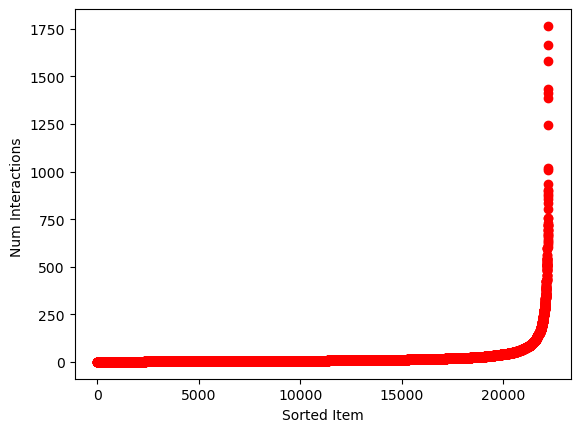

In [10]:
from matplotlib import pyplot

item_popularity = np.ediff1d(urm_all.tocsc().indptr)

item_popularity = np.sort(item_popularity)

pyplot.plot(item_popularity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted Item')
pyplot.show()

In [11]:
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity[int(n_items*0.45):int(n_items*0.55)].mean()))

print("Number of items with zero interactions {}".
      format(np.sum(item_popularity==0)))

Average per-item interactions over the whole dataset 21.54
Average per-item interactions for the top 10% popular items 122.73
Average per-item interactions for the least 10% popular items 2.35
Average per-item interactions for the median 10% popular items 8.37
Number of items with zero interactions 0


**The distribution of user activity**

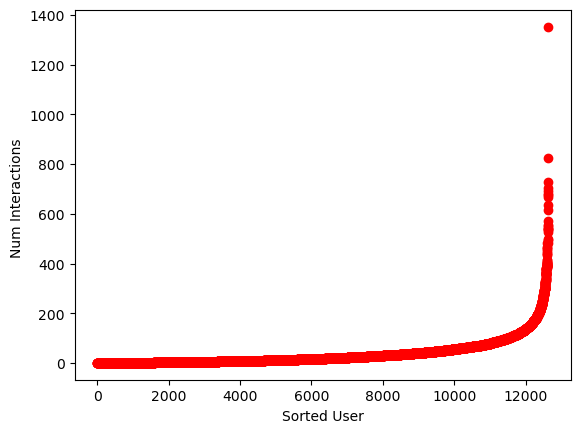

In [12]:
user_activity = np.ediff1d(urm_all.tocsr().indptr)
user_activity = np.sort(user_activity)


pyplot.plot(user_activity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted User')
pyplot.show()

In [13]:
ten_percent = int(n_items/10)

print("Average per-user interactions over the whole dataset {:.2f}".
      format(user_activity.mean()))

print("Average per-user interactions for the top 10% popular items {:.2f}".
      format(user_activity[-ten_percent:].mean()))

print("Average per-user interactions for the least 10% popular items {:.2f}".
      format(user_activity[:ten_percent].mean()))

print("Average per-user interactions for the median 10% popular items {:.2f}".
      format(user_activity[int(n_items*0.45):int(n_items*0.55)].mean()))

print("Number of user with zero interactions {}".
      format(np.sum(user_activity==0)))

Average per-user interactions over the whole dataset 37.88
Average per-user interactions for the top 10% popular items 129.63
Average per-user interactions for the least 10% popular items 1.88
Average per-user interactions for the median 10% popular items 91.34
Number of user with zero interactions 0


**Let's split the data into train and test**

In [14]:
train_test_split = 0.80

n_interactions = urm_all.nnz

train_mask = np.random.choice([True,False], n_interactions, p=[train_test_split, 1-train_test_split])
train_mask

urm_train = sps.csr_matrix((urm_all.data[train_mask],
                            (urm_all.row[train_mask], urm_all.col[train_mask])))


test_mask = np.logical_not(train_mask)

urm_test = sps.csr_matrix((urm_all.data[test_mask],
                            (urm_all.row[test_mask], urm_all.col[test_mask])))


In [15]:
def precision(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)

    return precision_score

def recall(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]

    return recall_score

def AP(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))

    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

In [16]:
def evaluate_algorithm(URM_test, recommender_object, at=5):

    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0

    num_eval = 0


    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]

        if len(relevant_items)>0:

            recommended_items = recommender_object.recommend(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)

    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval

    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP))

Here's the class for our predictor

In [82]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python 
class ItemKNNCFRecommender(object):
    
    def __init__(self, URM):
        self.URM = URM
        
            
    def fit(self, topK=50, shrink=100, normalize=True, similarity="cosine"):
        
        similarity_object = Compute_Similarity_Python(self.URM, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # Check if user_id is a valid index, otherwise use topRec results
        if user_id < 0 or user_id >= self.URM.shape[0]:
            print(f"Invalid user_id: {user_id}")
            return ["189 44 0 284 808 285 1 557 1266"]
        
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

# **Test our CF recommender**

**Let's split the data into train and test**

In [56]:
train_test_split = 0.80

n_interactions = urm_all.nnz

train_mask = np.random.choice([True,False], n_interactions, p=[train_test_split, 1-train_test_split])
train_mask

urm_train = sps.csr_matrix((urm_all.data[train_mask],
                            (urm_all.row[train_mask], urm_all.col[train_mask])))


test_mask = np.logical_not(train_mask)

urm_test = sps.csr_matrix((urm_all.data[test_mask],
                            (urm_all.row[test_mask], urm_all.col[test_mask])))


Here's the model:

In [58]:
recommender = ItemKNNCFRecommender(urm_train)
recommender.fit(shrink=0.0, topK=10)

Similarity column 22222 (100.0%), 1511.36 column/sec. Elapsed time 14.70 sec


**Now let's read the data we want to predict for and see if there're overlaps with UserIDs in train data**

In [26]:
urm_path = '../content/data_train.csv'

urm_all_orgdf = pd.read_csv(filepath_or_buffer=urm_path,
                                sep=",",
                                header=0,
                                dtype={0:int, 1:int, 2:float},
                                engine='python')

urm_all_orgdf.columns = ["UserID", "ItemID", "Interaction"]
len(urm_all_orgdf['UserID'])

478730

In [69]:
urm_path = '../content/data_target_users_test.csv'

urm_pred_df = pd.read_csv(filepath_or_buffer=urm_path,
                                sep=",",
                                header=0,
                                dtype={0:int},
                                engine='python')

urm_pred_df.columns = ["UserID"]
len(urm_pred_df['UserID'])
print('Unique user id to predict:', urm_pred_df['UserID'].nunique())

Unique user id to predict: 10882


Train  the model with the whole dataset

In [40]:
urm_all_train = sps.coo_matrix((urm_all_orgdf["Interaction"].values,
                          (urm_all_orgdf["UserID"].values, urm_all_orgdf["ItemID"].values)))

In [42]:
urm_all_train.tocsr()

<13025x22348 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [65]:
train_test_split = 1

n_interactions = urm_all.nnz

train_mask = np.random.choice([True,False], n_interactions, p=[train_test_split, 1-train_test_split])

urm_all_train = sps.csr_matrix((urm_all.data[train_mask],
                            (urm_all.row[train_mask], urm_all.col[train_mask])))

In [84]:
recommender = ItemKNNCFRecommender(urm_all_train)
recommender.fit(shrink=0.0, topK=10)

Similarity column 22222 (100.0%), 1442.58 column/sec. Elapsed time 15.40 sec


Now we make the predictions for every user in our test set and add them to pred_df

Here we list the users that are in our test set but not in our whole train set

In [70]:
users_not_in_orgdf = urm_pred_df[~urm_pred_df['UserID'].isin(urm_all_orgdf['UserID'])]

print("Users in urm_pred_df but not in urm_all_orgdf:")
print(users_not_in_orgdf)

Users in urm_pred_df but not in urm_all_orgdf:
       UserID
54         60
58         65
147       168
223       261
272       316
...       ...
10682   12775
10699   12798
10729   12837
10802   12921
10856   12992

[221 rows x 1 columns]


In [85]:
recommendations = recommender.recommend(12638, at=10)
print(recommendations)


Invalid user_id: 12638
['189 44 0 284 808 285 1 557 1266']


In [86]:
pred_df = pd.DataFrame(columns = ['user_id','item_list'])

for userid in urm_pred_df['UserID']:
  recommendations = recommender.recommend(userid, at=10)
  recommendations = " ".join(str(item) for item in recommendations)
  pred_df.loc[len(pred_df)] = [userid,recommendations]

Invalid user_id: 12638
Invalid user_id: 12639
Invalid user_id: 12640
Invalid user_id: 12641
Invalid user_id: 12642
Invalid user_id: 12643
Invalid user_id: 12644
Invalid user_id: 12648
Invalid user_id: 12649
Invalid user_id: 12650
Invalid user_id: 12653
Invalid user_id: 12654
Invalid user_id: 12655
Invalid user_id: 12656
Invalid user_id: 12657
Invalid user_id: 12659
Invalid user_id: 12661
Invalid user_id: 12662
Invalid user_id: 12663
Invalid user_id: 12664
Invalid user_id: 12665
Invalid user_id: 12666
Invalid user_id: 12668
Invalid user_id: 12669
Invalid user_id: 12670
Invalid user_id: 12671
Invalid user_id: 12672
Invalid user_id: 12673
Invalid user_id: 12674
Invalid user_id: 12676
Invalid user_id: 12677
Invalid user_id: 12678
Invalid user_id: 12679
Invalid user_id: 12680
Invalid user_id: 12682
Invalid user_id: 12684
Invalid user_id: 12685
Invalid user_id: 12687
Invalid user_id: 12688
Invalid user_id: 12689
Invalid user_id: 12690
Invalid user_id: 12691
Invalid user_id: 12692
Invalid use

In [87]:
pred_df

,user_id,item_list
0,1,2548 89 83 227 812 2612 819 88 815 1831
1,2,842 2545 8126 8304 8303 1427 4809 10737 4502 1424
2,3,227 812 589 815 2612 463 819 5767 8146 6282
3,4,4709 8688 8690 950 952 954 8693 15491 955 15832
4,5,5644 319 2 808 517 885 285 206 520 284
...,...,...
10877,13020,189 44 0 284 808 285 1 557 1266
10878,13021,189 44 0 284 808 285 1 557 1266
10879,13022,189 44 0 284 808 285 1 557 1266
10880,13023,189 44 0 284 808 285 1 557 1266


In [88]:
pred_df.to_csv('../content/predictionsCF.csv',index=False)